In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
#import example_utils as ex_utils

from MARBLE import dynamics,utils, geometry, net, plotting, postprocessing, preprocessing

# Define useful functions

In [68]:
from DE_library import simulate_trajectories
def reject_outliers(*args, min_v=-5, max_v=5):#possible to change the min_v/max_v
    inds = []
    for arg in args:
        inds.append(np.where((arg>min_v).all(1)*(arg<max_v).all(1))[0])
        
    return list(set.intersection(*map(set,inds)))

def simulate(mu, X0, t):
    p, v = simulate_trajectories('supcritical_hopf', X0, t, par = {'mu': mu, 'omega': 0.5, 'b': 1.0})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        if scaling:
            vel.append(np.sign(v_[ind])*np.abs(v_[ind])/(1+np.abs(v_[ind])))
        else:
            vel.append(v_[ind])#/np.linalg.norm(v_[ind],axis=1,keepdims=True))
    return pos, vel

In [69]:
def scale(v):
    return 20*np.sign(v)*np.abs(v)/(1+np.abs(v))

In [24]:
def cluster_perf(M):
    '''
    Computes the quality of clusterint of the symmetric matrix M
    '''
    n,_ = np.shape(M)
    mid = (n+1)//2
    m_11 = np.mean(M[:mid,:mid])
    m_22 = np.mean(M[mid:,mid:])
    m_12 = np.mean(M[mid:,:mid])
    cohesion = 2*np.sum((M[mid:,:mid]-m_12)**2)
    cohesion += np.sum((M[mid:,mid:]-m_22)**2)+np.sum((M[:mid,:mid]-m_11)**2)
    difference = (m_12-m_22)*(m_12-m_11)
    res = np.sqrt(cohesion/difference)/n
    return res

# Hyper-parameters

You can tune your hyper-parameters in the following cell. Other hyper-parameters are available in the code, but these are the main ones.

In [67]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 600
area = [[-1.,-1.],[1.,1.]]
n_steps=25
mu = np.hstack((np.linspace(-4.,4.,n_steps)))
grid_auto=False
scaling = False
use_diff = False # wether to use v_i-v_j or simply v_i

# Construction of tha data

In [70]:
pos, vel = [], []
if grid_auto:
    X0_range = dynamics.initial_conditions(n, len(mu), area)
else:
    sqrt_n = int(np.sqrt(n))
    X = np.linspace(area[0][0],area[1][0],sqrt_n)
    Y = np.linspace(area[0][1],area[1][1],sqrt_n)
    XY = np.array([[x,y] for x in X for y in Y])
    X0_range = [XY for _ in range(n_steps)]
    
if use_diff:
    scaling = False
    _,v_prec = simulate(mu[0], X0_range[0],t)
    v_prec = np.vstack(v_prec)
    v_prec = scale(v_prec)
    for i in range(1,len(mu)):
        p, v = simulate(mu[i], X0_range[i], t)
        v = np.vstack(v)
        v = scale(v)
        dv = v-v_prec
        v_prec=v
        pos.append(np.vstack(p))
        vel.append(dv)
    mu = mu[:-1]
else:
    for i, m in enumerate(mu):
        p, v = simulate(m, X0_range[i], t)
        if np.size(p): # avoid the empty arrays
            pos.append(np.vstack(p))
            vel.append(np.vstack(v))

/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


In [71]:
# precedent stop_crit=0.03
data = preprocessing.construct_dataset(pos, features=vel, k=40, stop_crit=0.03)#, vector=False)

---- Embedding dimension: 2
---- Signal dimension: 2

Embedding dimension <= 2, so manifold computations are disabled!

---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


# Plot vector fields

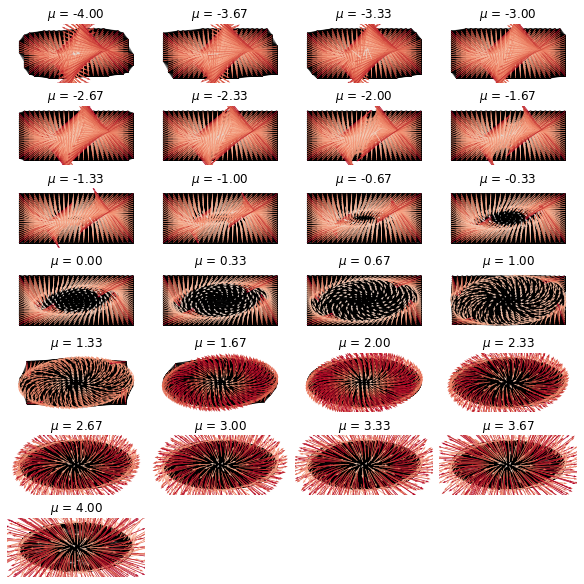

In [72]:
titles = [r'$\mu$ = {:0.2f}'.format(m) for m in mu]

axes = plotting.fields(data, col=4, alpha=0.5, titles=titles)

#plt.savefig('./outputs/parabolas.svg')

# Train network

In the variable par, you can modify the hyper-parameters of the MLP part.

In [73]:
par = {'epochs': 50, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = net(data, params=par)
model.run_training(data)
#model.load_model('./outputs/vanderpol_data/best_model.pth')


---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
include_self : True
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  450

---- Training network ...

Epoch: 0, Training loss: 1.232902, Validation loss: 1.1125, lr: 0.0100 *
Epoch: 1, Training loss: 1.098343, Validation loss: 1.0889, lr: 0.0100 *
Epoch: 2, Training loss: 1.087739, Validation loss: 1.0541, lr: 0.0100 *
Epoch: 3, Training loss: 1.062394, Validation loss: 1.0803, lr: 0.0100
Epoch: 4, Training loss: 1.047960, Validation loss: 1.0585, lr: 0.0100
Epoch: 5, Training loss: 1.028553, Validation loss: 1.0986, lr: 0.0100
Epoch: 6, Training loss: 1.035941, Validation loss: 1.0605, lr: 0.0100
Epo

# Plots

## Embeddings and distance matrix

Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


<Figure size 288x288 with 0 Axes>

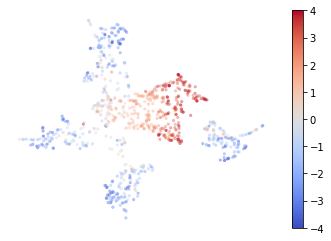

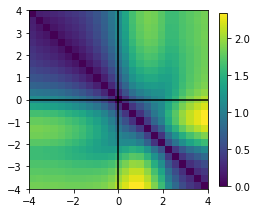

<Figure size 288x288 with 0 Axes>

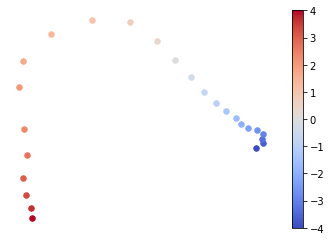

In [74]:
data = model.evaluate(data)
data = postprocessing.distribution_distances(data)
data = postprocessing.embed_in_2D(data)

plt.figure(figsize=(4, 4))
plotting.embedding(data, mu[data.y.numpy().astype(int)])

plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, extent=[mu[0], mu[-1], mu[0], mu[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)

emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')

plt.figure(figsize=(4, 4))
plotting.embedding(emb_MDS, mu, s=30, alpha=1)
plt.show()

#plt.savefig('../results/van_der_pol_MDS.svg')

In [75]:
# compute the clustering performance (i.e quality of clustering) for the last run
cluster_perf(data.dist)

0.6194194811225376

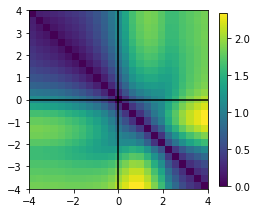

In [76]:
# to save the distance matrix
plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, extent=[mu[0], mu[-1], mu[0], mu[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)
plt.savefig('./results/supcrithopf_dist_mat.png')

## Neighborhoods

Run the followinf cell to plot the different types of neighborhoods

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6a2f1f6280>
Traceback (most recent call last):
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6a1f637550>
Traceback (most recent call last):
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/nfs_home/jegou/miniconda3/envs/pytorch-compat/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Performed umap embedding on embedded results.


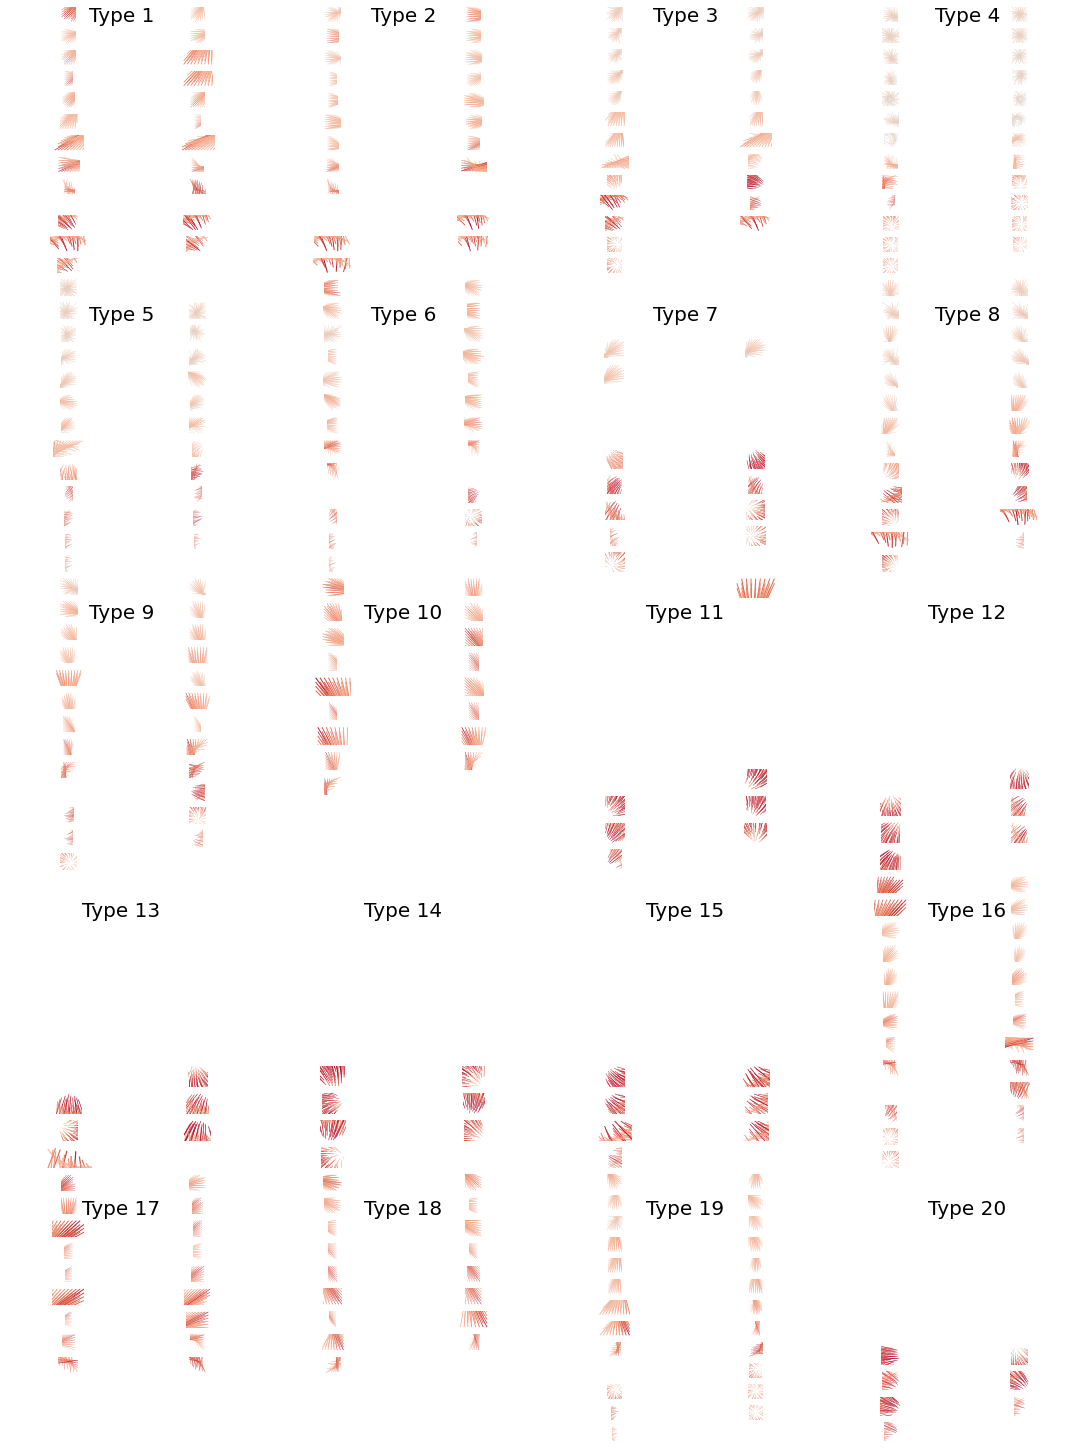

In [77]:
#data = model.evaluate(data)
data = postprocessing.distribution_distances(data, n_clusters=20,cluster_typ='kmeans')
data = postprocessing.embed_in_2D(data)
plotting.neighbourhoods(data)

## Clusters and embeddings

<Axes: >

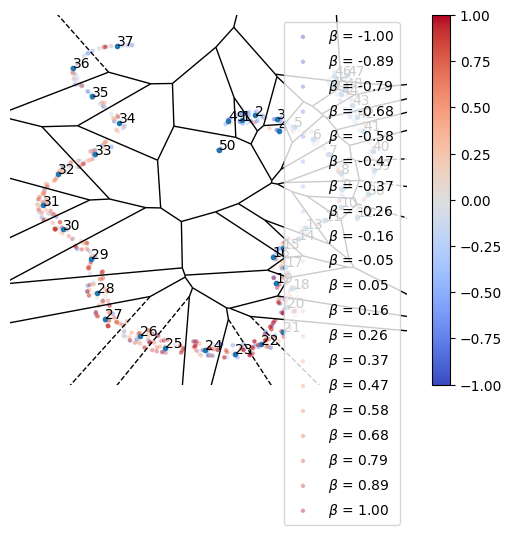

In [210]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]
plotting.embedding(data, mu[data.y.numpy().astype(int)], titles=titles)
#plt.savefig('../results/van_der_pol_embedding.svg')

# Performance of clustering

To create graphs of the type Quality of clustering = f(hyper-parameter). You can choose the hyper-parameter to study and the values it should take. Then, modify the loop where this parameter is used (usually used only once), and execute the cell.

In [16]:
N_param = 10 # number of hyper-parameters to sample
parameter = np.linspace(1,20,N_param) # sampling
param_name = 'mu' # for the plots
perf = np.zeros(N_param) # array of quality of clutering

n = 100
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
area = [[-10,-10],[10,10]]
n_steps=20
grid_auto=False
scaling = False
use_diff = False
mu = np.hstack((np.linspace(-1.,1.,n_steps)))

for j in range(N_param): # for each hyper-parameter, run the algorithm
    mu = np.hstack((np.linspace(-parameter[j],parameter[j],n_steps)))
    try: # there are often errors -> set the quality to 0
        if grid_auto:
            X0_range = dynamics.initial_conditions(n, len(mu), area)
        else:
            sqrt_n = int(np.sqrt(n))
            X = np.linspace(area[0][0],area[1][0],sqrt_n)
            Y = np.linspace(area[0][1],area[1][1],sqrt_n)
            XY = np.array([[x,y] for x in X for y in Y])
            X0_range = [XY for _ in range(n_steps)]
        
        pos, vel = [], []
        if use_diff:
            scaling = False
            _,v_prec = simulate(mu[0], X0_range[0],t)
            v_prec = np.vstack(v_prec)
            v_prec = scale(v_prec)
            for i in range(1,len(mu)):
                p, v = simulate(mu[i], X0_range[i], t)
                v = np.vstack(v)
                v = scale(v)
                dv = v-v_prec
                v_prec=v
                pos.append(np.vstack(p))
                vel.append(dv)
            mu = mu[:-1]
        else:
            for i, m in enumerate(mu):
                p, v = simulate(m, X0_range[i], t)
                pos.append(np.vstack(p))
                vel.append(np.vstack(v))

        data = preprocessing.construct_dataset(pos, features=vel, k=45, stop_crit=0.03)

        par = {'epochs': 50, #optimisation epochs
               'order': 2, #order of derivatives
               'hidden_channels': 32, #number of internal dimensions in MLP
               'out_channels': 5,
               'inner_product_features': True,
              }
        model = net(data, params=par)
        model.run_training(data)
        data = model.evaluate(data)
        
        data = postprocessing.distribution_distances(data)

        data = postprocessing.embed_in_2D(data)
        
        perf[j] = cluster_perf(data.dist)
    except Exception as e:
        print('-'*25)
        print(e)
        print('-'*25)
        perf[j]=0
        continue
    print('%d/%d done'%(j+1,N_param))

---- Embedding dimension: 2
---- Signal dimension: 2

Embedding dimension <= 2, so manifold computations are disabled!

---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
include_self : True
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  450

---- Training network ...

Epoch: 0, Training loss: 1.387071, Validation loss: 1.3815, lr: 0.0100 *
Epoch: 1, Training loss: 1.381010, Validation loss: 1.3806, lr: 0.0100 *
Epoch: 2, Training loss: 1.378783, Validation loss: 1.3818, lr: 0.0100
Epoch: 3, Training loss: 1.374183, Validation loss: 1.3762, lr: 0.0100 *
Epoch: 4, Training 

Epoch: 33, Training loss: 1.136053, Validation loss: 1.0931, lr: 0.0100
Epoch: 34, Training loss: 1.162323, Validation loss: 1.0403, lr: 0.0100 *
Epoch: 35, Training loss: 1.152246, Validation loss: 1.0320, lr: 0.0100 *
Epoch: 36, Training loss: 1.113950, Validation loss: 1.1456, lr: 0.0100
Epoch: 37, Training loss: 1.111536, Validation loss: 1.1525, lr: 0.0100
Epoch: 38, Training loss: 1.146504, Validation loss: 1.1489, lr: 0.0100
Epoch: 39, Training loss: 1.120435, Validation loss: 1.0230, lr: 0.0100 *
Epoch: 40, Training loss: 1.134824, Validation loss: 1.0282, lr: 0.0100
Epoch: 41, Training loss: 1.128981, Validation loss: 1.0413, lr: 0.0100
Epoch: 42, Training loss: 1.147131, Validation loss: 0.9990, lr: 0.0100 *
Epoch: 43, Training loss: 1.104851, Validation loss: 1.0486, lr: 0.0100
Epoch: 44, Training loss: 1.128711, Validation loss: 1.1031, lr: 0.0100
Epoch: 45, Training loss: 1.141724, Validation loss: 1.1805, lr: 0.0100
Epoch: 46, Training loss: 1.103394, Validation loss: 1.1

Epoch: 16, Training loss: 1.193787, Validation loss: 1.2298, lr: 0.0100
Epoch: 17, Training loss: 1.194459, Validation loss: 1.2721, lr: 0.0100
Epoch: 18, Training loss: 1.214261, Validation loss: 1.1093, lr: 0.0100
Epoch: 19, Training loss: 1.193128, Validation loss: 1.0439, lr: 0.0100 *
Epoch: 20, Training loss: 1.154011, Validation loss: 1.0190, lr: 0.0100 *
Epoch: 21, Training loss: 1.178118, Validation loss: 1.1866, lr: 0.0100
Epoch: 22, Training loss: 1.187427, Validation loss: 1.1603, lr: 0.0100
Epoch: 23, Training loss: 1.194615, Validation loss: 1.1850, lr: 0.0100
Epoch: 24, Training loss: 1.172839, Validation loss: 1.1182, lr: 0.0100
Epoch: 25, Training loss: 1.171369, Validation loss: 1.1344, lr: 0.0100
Epoch: 26, Training loss: 1.188412, Validation loss: 1.1580, lr: 0.0100
Epoch: 27, Training loss: 1.129534, Validation loss: 1.1735, lr: 0.0100
Epoch: 28, Training loss: 1.178546, Validation loss: 1.1209, lr: 0.0100
Epoch: 29, Training loss: 1.174740, Validation loss: 1.1736,

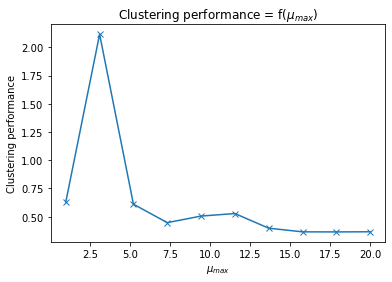

In [18]:
# cell to plot & save the result
plt.plot(parameter,perf,marker='x')
#plt.xscale('log')
plt.xlabel(param_name)
plt.ylabel('Clustering performance')
plt.title('Clustering performance = f(%s)'%param_name)
plt.savefig('./results/supcrithopf_perf_%s'%param_name)